# Sum of sinusoids benchmark for e-prop

## Goal: Shape random noise/spikes into target sum of sinusoids function

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


# from torchvision.datasets import MNIST
# from torchvision import transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F

import snntorch as snn 
from snntorch import spikegen
# from snntorch.spikevision import spikedata
import snntorch.spikeplot as splt

## Set useful parameters

In [2]:
params= {
    'dtype'     : torch.float32,
    'n_batch'     : 1,             # batch size of the testing set
    'n_out'       : 1,             # number of output neurons (number of target curves)
    'n_in'        : 100 ,          # number of input units
    'n_rec'       : 100,           # number of recurrent units

    'f0'          : 50 ,           # input firing rate
    'reg_rate'    : 10 ,           # target rate for regularization

    'n_iter'      : 2000 ,         # number of iterations/epochs
    'seq_len'     : 1000  ,         # number of time steps per sequence
    'print_every' : 10  ,          # print statistics every K iterations

    'dampening_factor' : 0.3,      # dampening factor to stabilize learning in RNNs
    'learning_rate'  : 1e-4,       # learning rate
    'reg'         : 300,           # regularization coefficient

    'dt'          : 1. ,           # (ms) simulation step
    'thr'         : 0.03,          # threshold at which the LSNN neurons spike (in arbitrary units)

    'do_plot'     : True,          # interactive plots during training
    'random_feedback' : False,     # use random feedback if true, otherwise take the symmetric of the readout weights
    'stop_z_gradients' : True,    # stop gradients in the model dynamics to get mathematical equivalence between eprop and BPTT
    'gradient_check' : True,       # verify that the gradients computed with e-prop match the gradients of BPTT
    'eprop_or_bptt' : 'eprop',     # choose the learing rule, it should be `eprop` of `bptt`'
    }

# explicitate some of the parameters to lighten syntax
dtype = params['dtype']

# Experiment parameters
dt = 1  # time step in ms
input_f0 = params['f0'] / 1000  # input firing rate in kHz in coherence with the usage of ms for time
regularization_f0 = params['reg_rate'] / 1000  # desired average firing rate in kHz
tau_m = tau_m_readout = 30
thr = params['thr']
params['tau_m'] = tau_m
params['tau_m_readout'] = tau_m_readout
params['regularization_f0'] = regularization_f0

## Generate training sinusoids

In [3]:
def sum_of_sines_target(seq_len, n_sines=4, periods=[1000, 500, 333, 200], weights=None, phases=None, normalize=True):
    '''
    Generate a target signal as a weighted sum of sinusoids with random weights and phases.
    :param n_sines: number of sinusoids to combine
    :param periods: list of sinusoid periods
    :param weights: weight assigned the sinusoids
    :param phases: phases of the sinusoids
    :return: one dimensional vector of size seq_len contained the weighted sum of sinusoids
    '''
    if periods is None:
        periods = [np.random.uniform(low=100, high=1000) for i in range(n_sines)]
    assert n_sines == len(periods)
    sines = []
    weights = np.random.uniform(low=0.5, high=2, size=n_sines) if weights is None else weights
    phases = np.random.uniform(low=0., high=np.pi * 2, size=n_sines) if phases is None else phases
    for i in range(n_sines):
        sine = np.sin(np.linspace(0 + phases[i], np.pi * 2 * (seq_len // periods[i]) + phases[i], seq_len))
        sines.append(sine * weights[i])

    output = sum(sines)
    if normalize:
        output = output - output[0]
        scale = max(np.abs(np.min(output)), np.abs(np.max(output)))
        output = output / np.maximum(scale, 1e-6)
    return output

In [4]:
# build the output pattern (note that the [None,:] adds an extra dimension of size 1 to the tensor)
# dimentions: [batch=1, time_steps=1000, neurons=1]
target_sinusoidal_outputs = [sum_of_sines_target(params['seq_len'])[None, :] for i in range(params['n_out'])]
target_sinusoidal_outputs = torch.from_numpy(np.stack(target_sinusoidal_outputs, axis=2)).type(dtype=params["dtype"])
print(f"target_sinusoidal_outputs shape: {target_sinusoidal_outputs.shape}")

target_sinusoidal_outputs shape: torch.Size([1, 1000, 1])


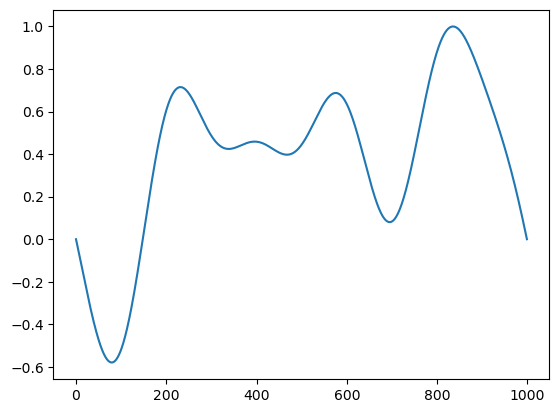

In [5]:
# Visualise first example in batch
plt.plot(target_sinusoidal_outputs[0])

In [6]:
# Generate random input spikes
# dimentions: [batch=1, time_steps=1000, n_in=100]
frozen_poisson_noise_input = np.random.rand(params['n_batch'], params['seq_len'], params['n_in']) < dt * input_f0  # why sampling period * input frequency? = [spikes]
input_spikes = torch.from_numpy(frozen_poisson_noise_input).type( dtype=dtype )
print(input_spikes.shape)

torch.Size([1, 1000, 100])


Text(0.5, 1.0, 'Spike train for 0th input')

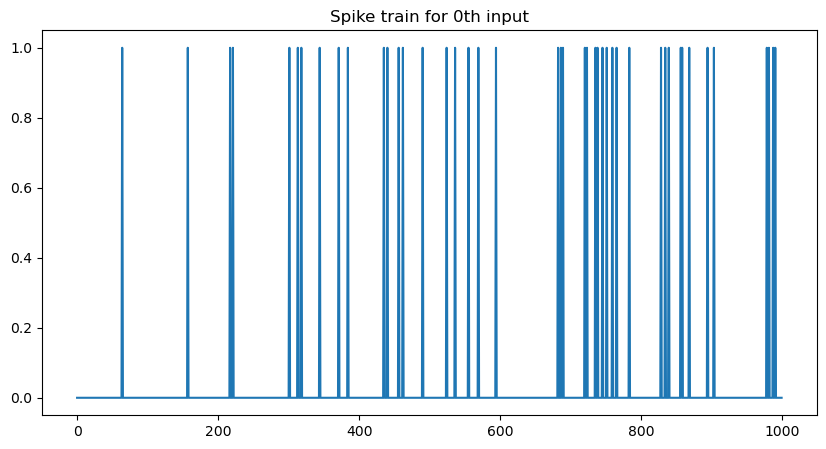

In [7]:
plt.figure(figsize=(10,5))
plt.plot(input_spikes[0, :, 0])
plt.title("Spike train for 0th input")

### Create DataLoader

`TODO:`

## Define Network

For now, feed each frame one by one to network, flattening the polarities (ON and OFF events)

In [8]:
# TAU_MEM = tau_m  # 500 ms
# TAU_OUT = tau_m_readout  # 20 ms
# GAMMA = params["dampening_factor"]
# DT = 1  # 1s TODO: Find appropriate time constants and timestep size
# THRESHOLD = params["thr"]
# NUM_STEPS = params["seq_len"]  

# NUM_INPUTS = input_spikes.shape[-1]  # [BS, timesteps, neurons]
# NUM_RECS= 64  # Design choice, number of recurrent neurons
# NUM_OUTPUTS = target_sinusoidal_outputs.shape[-1]  # Number of output neurons
# CLASSIFICATION = False  # True: Classification, False: Regression
# print(f"NUM_INPUTS: {NUM_INPUTS}, NUM_HIDDENS: {NUM_RECS}, NUM_OUTPUTS: {NUM_OUTPUTS}")

# device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [9]:
TAU_MEM = 20e-3  # 50 ms
TAU_OUT = 20e-3  # 20 ms
GAMMA = 0.3
DT = 1e-3  # 1s TODO: Find appropriate time constants and timestep size
THRESHOLD = 1.0
NUM_STEPS = params["seq_len"]

NUM_INPUTS = input_spikes.shape[-1]  # [BS, timesteps, neurons]
NUM_RECS= 64  # Design choice, number of recurrent neurons
NUM_OUTPUTS = target_sinusoidal_outputs.shape[-1]  # Number of output neurons
CLASSIFICATION = False
print(f"NUM_INPUTS: {NUM_INPUTS}, NUM_HIDDENS: {NUM_RECS}, NUM_OUTPUTS: {NUM_OUTPUTS}")

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
check_gradients = True

NUM_INPUTS: 100, NUM_HIDDENS: 64, NUM_OUTPUTS: 1


## Hardcoded network

In [55]:
# Define pseudo-derivative to tackle non-differentiability of the spike function

class SpikeFunction(torch.autograd.Function):
    """Applies Heaviside function in forward pass,
    and pseudo-derivative in backward pass.
    """
    @staticmethod
    def forward(ctx, input: torch.Tensor, threshold: float, damping_factor: float = 0.3):
        """Forward pass: compute activation for each input element (voltage).
        Parameters:
            ctx: context object to stash information for backward pass.
            input: input tensor (membrane voltages)
            threshold: firing threshold
            damping_factor: damping factor for pseudo-derivative
        Returns:
            output tensor (spikes)
        """
        ctx.save_for_backward(input)
        ctx.threshold = threshold  # threshold is not a Tensor
        ctx.damping_factor = damping_factor
        return input.gt(threshold).float()

    @staticmethod
    def backward(ctx, grad_output: torch.Tensor):
        input, = ctx.saved_tensors
        threshold, damping_factor = ctx.threshold, ctx.damping_factor
        grad_input = None

        if ctx.needs_input_grad[0]:
            pseudo_deriv = damping_factor * torch.maximum(torch.tensor([0]), 1-torch.abs((input-threshold)/threshold))
            # Element-wise multiplication
            grad_input = grad_output.mul(pseudo_deriv)
        return grad_input, None, None
    
spike_fn = SpikeFunction.apply

In [56]:
v_mem = torch.rand(10, requires_grad=True)  # 10[neurons]
spikes = SpikeFunction.apply(v_mem, 0.5)
print(v_mem)
print(spikes)
spikes.backward(torch.ones_like(spikes))
print(v_mem.grad)

tensor([0.7469, 0.0948, 0.4075, 0.5404, 0.3239, 0.8151, 0.0134, 0.5440, 0.2391,
        0.8031], requires_grad=True)
tensor([1., 0., 0., 1., 0., 1., 0., 1., 0., 1.],
       grad_fn=<SpikeFunctionBackward>)
tensor([0.1519, 0.0569, 0.2445, 0.2758, 0.1944, 0.1109, 0.0080, 0.2736, 0.1435,
        0.1181])


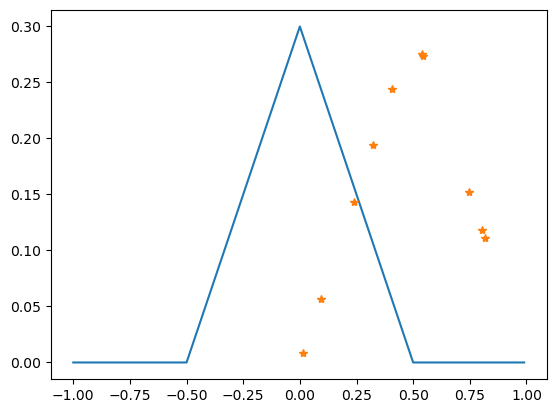

In [57]:
input = torch.arange(-1, 1, 0.01)
pseudo_deriv = 0.3 * torch.maximum(torch.tensor([0]), 1-torch.abs(input/0.5))
plt.plot(input, pseudo_deriv, label="input")
plt.plot(v_mem.detach(), v_mem.grad.detach(), "*")

In [65]:
import torch.nn.functional as F

class RSNN(nn.Module):
    """Simple RSNN as in e-prop paper.
    I.e. Inputs -> Recurrent LIF Neurons -> Output LIF Neurons
    """
    def __init__(self, num_inputs: int, num_rec: int, num_outputs: int, classification: bool, 
            tau_mem: float, tau_out: float, dt, gamma: float, threshold: float, 
            device, lr: float=1e-4, num_timesteps=3, w_init_gain: list[float]=[1.0, 1.0, 1.0],
            check_gradients: bool=False):
        """Initialise hyperparameters and architecture"""
        super().__init__()  # Get good stuff from torch.nn.Module

        self.device = device
        self.check_gradients = check_gradients

        # Optimiser Hyperparameters
        self.lr = lr

        # SNN Hyperparameters
        self.tau_mem = tau_mem                  # Decay time constant for recurrent membrane potentials
        self.tau_out = tau_out                  # Decay time constant for output membrane potentials
        self.dt = dt                            # Timestep size
        self.alpha = np.exp(-dt/tau_mem)        # Recurrent membrane potential decay rate
        self.gamma = gamma                      # Constant in pseudo-deriv
        self.kappa = np.exp(-dt/tau_out)        # Output membrane potential decay rate
        self.threshold = threshold              # Membrane voltage threshold

        self.T = num_timesteps                  # Number of timesteps per example (3 for NMNIST saccades)

        # Architecture params
        self.n_in = num_inputs
        self.n_rec = num_rec
        self.n_out = num_outputs
        self.classification = classification

        # Declare network weights
        self.w_in = nn.Parameter(torch.Tensor(self.n_rec, self.n_in))
        # Disable self connections in recurrent layer
        w_rec = torch.Tensor(self.n_rec, self.n_rec) * (1-torch.eye(self.n_rec, self.n_rec, device=self.device))
        self.w_rec = nn.Parameter(w_rec)
        self.w_out = nn.Parameter(torch.Tensor(self.n_out, self.n_rec))
        self.output_bias = 0.
        # self.b_out = nn.Parameter(torch.zeros(self.n_out))  # Output Bias

        # Create mask for recurrent weights
        self.w_rec_mask = 1-torch.eye(self.n_rec, self.n_rec, device=self.device)

        w_init_gain = 7.
        self.init_params(w_init_gain)

        # Initialise manual grad attributes
        self.w_in_grad = torch.zeros_like(self.w_in)
        self.w_rec_grad = torch.zeros_like(self.w_rec)
        self.w_out_grad = torch.zeros_like(self.w_out)
        # self.b_out_grad = torch.zeros_like(self.b_out)  

    def init_params(self, gain):
        """Perform He Initialisation on network parameters"""
        # nn.init.kaiming_normal_(self.w_in, mode="fan_in", nonlinearity="relu")
        # self.w_in.data *= gain[0]
        # nn.init.kaiming_normal_(self.w_rec, mode="fan_in", nonlinearity="relu")
        # self.w_rec.data += gain[1]
        # nn.init.kaiming_normal_(self.w_out, mode="fan_in", nonlinearity="relu")
        # self.w_out.data += gain[2]

        # Try Xavier init with scale rel to decay rate
        weight_scale = gain*(1 - self.alpha)  # Can multiply this as well
        nn.init.normal_(self.w_in, mean=0, std=weight_scale/np.sqrt(self.n_in))
        nn.init.normal_(self.w_rec, mean=0, std=weight_scale/np.sqrt(self.n_rec))
        nn.init.normal_(self.w_out, mean=0, std=weight_scale/np.sqrt(self.n_rec))

    def reset_network(self):
        """Set membrane potentials, spikes, and gradients to zero.
        Used after feeding in an example, to prepare for next.
        """
        # Recurrent hidden state and output spikes
        self.v = torch.zeros(self.T, self.BS, self.n_rec).to(self.device)
        self.z = torch.zeros(self.T, self.BS, self.n_rec).to(self.device)

        # Output hidden state
        self.vo = torch.zeros(self.T, self.BS, self.n_out).to(self.device)
        # TODO: Can use output spikes as well

        # Gradients
        self.w_in_grad = torch.zeros_like(self.w_in)
        self.w_rec_grad = torch.zeros_like(self.w_rec)
        self.w_out_grad = torch.zeros_like(self.w_out)
        # self.b_out_grad = torch.zeros_like(self.b_out)

    def forward(self, x: torch.Tensor):
        """Feed example through RSNN
        Parameters:
            x: Inputs to RSNN, [T, BS, features...]
        Returns:
            yo: Output probabilities, [T, BS, num_outputs]
            vo: Output membrane potentials, [T, BS, num_outputs]
        """

        # Extract batch size and flatten x features
        self.BS= x.shape[1]  # x shape: [T, BS, features...]
        # x = x.flatten(start_dim=2)  # Flatten after [time, batch_size, ...]

        # Reset membrane potentials and gradients
        self.reset_network()

        # Ensure no self connections
        # with torch.no_grad():
        # self.w_rec.data = self.w_rec.data * (1 - torch.eye(self.n_rec, self.n_rec, device=self.device))

        # Debug
        # print(f"v: {self.v.shape}, v[t]: {self.v[0].shape}")
        # print(f"x: {x.shape}, x[t]: {x[0].shape}")

        # self.z.detach()

        # Allocate new memory to avoid inplace operations
        v = []
        z = []
        vo = []

        # Add initial membrane potentials
        v.append(self.v[0])
        z.append(self.z[0])
        vo.append(self.vo[0])

        
        for t in range(self.T - 1):
            # self.v[t+1] = (self.alpha*self.v[t] + self.z[t].mm(self.w_rec.t()) + x[t].mm(self.w_in.t()) - self.z[t]*self.threshold)  # z[t], x[t] row vectors, i.e. [1, N_REC]
            # self.v[t+1].copy_()
            v_t = self.alpha*v[t] + z[t].mm((self.w_rec).t()) + x[t].mm(self.w_in.t()) - z[t].detach()*self.threshold

            # print(f"self.z[t].mm(self.w_rec.t()): {self.z[t].mm(self.w_rec.t()).shape}")
            # print(f"x[t].mm(self.w_in.t()): {x[t].mm(self.w_in.t()).shape}")
            # print(f"self.v[t+1]: {self.v[t+1].shape}")

            # self.z[t+1] = (self.v[t+1] > self.threshold).float()
            # self.z[t+1] = SpikeFunction.apply(self.v[t+1], self.threshold, self.gamma)
            # self.z[t+1] = spike_fn(v_t, self.threshold, self.gamma)
            z_t = SpikeFunction.apply(v_t, self.threshold, self.gamma)

            
            # print(f"self.z[t+1]: {self.z[t+1].shape}")
            # print(f"self.z[t].mm(self.w_out.t()): {self.z[t].mm(self.w_out.t()).shape}")

            # self.vo[t+1] = self.kappa*self.vo[t] + self.z[t].mm(self.w_out.t()) + self.output_bias
            # self.vo[t+1].copy_(self.kappa * self.vo[t] + self.z[t].mm(self.w_out.t()) + self.output_bias)
            vo_t = self.kappa*vo[t] + z[t].mm(self.w_out.t()) + self.output_bias

            v.append(v_t)
            z.append(z_t)
            vo.append(vo_t)
        
        # Set vo and v to tensors
        self.v = torch.stack(v, dim=0)  # [T, BS, N_REC]
        self.z = torch.stack(z, dim=0)
        self.vo = torch.stack(vo, dim=0)
        
        # Apply softmax for classification
        if self.classification:
            self.yo = F.softmax(self.vo, dim=2)  # vo shape: [T, BS, num_outputs]
        else:  # Regression on membrane voltage
            self.yo = self.vo

        return self.yo, self.vo
    
    def calc_loss(self, vo, y_target) -> torch.Tensor:
        """Calculate model loss (using output membrane potentials)

        Parameters:
            vo: Output membrane potentials [T, BS, NUM_OUTPUTS]
            y_target: In case of CE loss, index of correct class (not one-hot),
                        size, [BATCH_SIZE].
                        If MSE, target regression value, size [T, BS, n_out]
        Returns:
            loss_val: scalar
        
        N.B. Usually must y_target.swapaxes(1,0) before passing to this method,
        since dataloader will give [BS, T, ...]
        
        """
        # print(f"vo: {vo.shape}")
        # print(f"y_target: {y_target.shape} should be {[1]}")
        # print(f"CELoss: {F.mse_loss(vo[0], y_target[0, :, :]).shape}")
        loss_val = torch.zeros((1), dtype=float, device=self.device)
        for t in range(self.T):
            if self.classification:
                loss_val += F.cross_entropy(vo[t], y_target)
            else:
                loss_val += F.mse_loss(vo[t], y_target[t, :, :])
        return loss_val

    
    def calc_grads(self, x: torch.Tensor, yo: torch.Tensor, y_target: torch.Tensor):
        """Calculate learning signals, eligility traces and set .grad attributes"""

        # Surrogate derivative, N.B. gamma is gamma_d/v_th
        psi = self.gamma*torch.maximum(torch.zeros_like(self.v), 1-torch.abs((self.v-self.threshold)/self.threshold))
        

        # Pseudocode:
        # eligibility_vectors = low pass filtered inputs
        # eligibility_traces = psi * eligibility_vectors
        # Gradients = Learning signal * eligibility_traces

        # Eligibility traces for input and reccurent weights
        alpha_conv  = torch.tensor([self.alpha ** (self.T-i-1) for i in range(self.T)]).float().view(1,1,-1).to(self.device)
        elig_vec_in    = F.conv1d(x.permute(1,2,0), alpha_conv.expand(self.n_in ,-1,-1), padding=self.T, groups=self.n_in )[:,:,1:self.T+1].unsqueeze(1).expand(-1,self.n_rec,-1,-1)  #n_b, n_rec, n_in , n_t 
        elig_trace_in    = torch.einsum('tbr,brit->brit', psi, elig_vec_in)                                                                                                                          #n_b, n_rec, n_in , n_t 
        elig_vec_rec   = F.conv1d(self.z.permute(1,2,0), alpha_conv.expand(self.n_rec,-1,-1), padding=self.T, groups=self.n_rec)[:,:, :self.T].unsqueeze(1).expand(-1,self.n_rec,-1,-1)  #n_b, n_rec, n_rec, n_t
        elig_trace_rec   = torch.einsum('tbr,brit->brit', psi, elig_vec_rec)

        # Eligibility vectors for output weights
        kappa_conv = torch.tensor([self.kappa ** (self.T-i-1) for i in range(self.T)]).float().view(1,1,-1).to(self.device)
        elig_vec_out = F.conv1d(self.z.permute(1,2,0), kappa_conv.expand(self.n_rec,-1,-1), padding=self.T, groups=self.n_rec)[:,:,1:self.T+1]

        # Low pass filtered eligibility traces for input and recurrent weights
        e_bar_in = F.conv1d(elig_trace_in.reshape(self.BS, self.n_in *self.n_rec, self.T), kappa_conv.expand(self.n_in*self.n_rec,-1,-1), padding=self.T, groups=self.n_in *self.n_rec)[:,:,1:self.T+1].reshape(self.BS,self.n_rec,self.n_in ,self.T)   #n_b, n_rec, n_in , n_t
        e_bar_rec = F.conv1d(elig_trace_rec.reshape(self.BS,self.n_rec*self.n_rec,self.T), kappa_conv.expand(self.n_rec*self.n_rec,-1,-1), padding=self.T, groups=self.n_rec*self.n_rec)[:,:,1:self.T+1].reshape(self.BS,self.n_rec,self.n_rec,self.T)   #n_b, n_rec, n_rec, n_t

        # Learning signals
        # TODO: yo is for every timestep, y_target needs to be for every time, and one-hot coded [T, BS, NUM_OUT]
        if self.classification:
            y_target = F.one_hot(y_target.long(), num_classes=self.n_out)
        error = yo - y_target
        L = torch.einsum('tbo,or->brt', error, self.w_out)

        # TODO: Only compute network updates on timestepswhen target is present?

        # Update weight .grad attributes
        w_rec_grad = torch.sum(L.unsqueeze(2).expand(-1,-1,self.n_rec,-1) * e_bar_rec, dim=(0,3))
        # TODO: Add flag to toggle gradient checking, if false directly set .grad attributes
        if self.check_gradients:
            self.w_in_grad  = torch.sum(L.unsqueeze(2).expand(-1,-1,self.n_in ,-1) * e_bar_in , dim=(0,3)) 
            self.w_rec_grad = w_rec_grad * self.w_rec_mask  # Only update non-self connections
            self.w_out_grad = torch.einsum('tbo,brt->or', error, elig_vec_out)
            # self.b_out_grad = torch.sum(error, dim=(0,1))
        else:
            self.w_in.grad += torch.sum(L.unsqueeze(2).expand(-1,-1,self.n_in ,-1) * e_bar_in , dim=(0,3))
            self.w_rec.grad += w_rec_grad * self.w_rec_mask
            self.w_out.grad += torch.einsum('tbo,brt->or', error, elig_vec_out)
            # self.b_out.grad += torch.sum(error, dim=(0,1))
    
    def update_weights(self):
        """Manually update weights using _grad attributes.

        Simply Vanilla SGD for now.
        """
        with torch.no_grad():
            self.w_in  -= self.lr * self.w_in_grad
            self.w_rec -= self.lr * self.w_rec_grad
            self.w_out -= self.lr * self.w_out_grad
            # self.b_out -= self.lr * self.b_out_grad
    
    def grad_error(self, loss_val: torch.Tensor):
        """Calculate gradient error between eprop and bptt"""
        params = [self.w_in, self.w_rec, self.w_out]
        grad_bptt = torch.autograd.grad(loss_val, params, create_graph=True, allow_unused=True)
        with torch.no_grad():
            grad_eprop = [self.w_in_grad, self.w_rec_grad, self.w_out_grad]
            # grad_error = torch.stack([((grad_bptt[i] - grad_eprop[i])).sum() for i in range(len(grad_bptt))])
            grad_error = []
            for i in range(len(grad_bptt)):
                if grad_bptt[i] is None:
                    grad_error.append(torch.zeros_like(grad_eprop[i]))
                else:
                    grad_error.append(grad_bptt[i] - grad_eprop[i])
        
        return grad_error

net = RSNN(num_inputs=NUM_INPUTS,
           num_rec=NUM_RECS,
           num_outputs=NUM_OUTPUTS,
           classification=CLASSIFICATION,
           tau_mem=TAU_MEM,
           tau_out=TAU_OUT,
           dt=DT,
           gamma=GAMMA,
           threshold=THRESHOLD,
           device=device,
           num_timesteps=params["seq_len"],
           lr=params["learning_rate"],
           check_gradients=check_gradients
).to(device)

### Print network diagnostics

In [66]:
net.alpha, net.kappa

(0.951229424500714, 0.951229424500714)

In [67]:
net.w_in.sum(dim=1)

tensor([-0.3360, -0.1814, -0.0244,  0.0114, -0.0098,  0.5149,  0.1005, -0.1192,
        -0.1993, -0.4358, -0.5756,  0.2967,  0.0957,  0.6953,  0.1217,  0.1368,
        -0.0136, -0.0399,  0.1031, -0.4835, -0.1483, -0.4279, -0.0672,  0.3350,
        -0.1395,  0.3343, -0.2937, -0.5130,  0.1421, -0.5139,  0.0405, -0.1492,
         0.0604,  0.2230, -0.1014, -0.3067, -0.0805,  0.5664,  0.3500, -0.8692,
        -0.4627, -0.2089,  0.2271, -0.1763, -0.0469, -0.2028,  0.0657, -0.4290,
        -0.2297, -0.4102,  0.1985, -0.6506, -0.4439,  0.1442, -0.3731,  0.9304,
        -0.2995, -0.5922,  0.8164, -0.5703, -0.2887, -0.2571, -0.1245,  0.2640],
       grad_fn=<SumBackward1>)

In [68]:
net.w_rec.sum(dim=1)

tensor([ 0.2369, -0.5682,  0.5311, -0.4707,  0.0223,  0.1553,  0.3962, -0.4052,
        -0.3511,  0.1812, -0.1388, -0.2816,  0.3918,  0.3365,  0.2743, -0.2711,
         0.4251, -0.0287,  0.1034, -0.3874,  0.3353, -0.0217, -0.1166, -0.2893,
        -0.3152,  0.0824, -0.5106,  0.3353, -0.3231,  0.4879,  0.1280,  0.6189,
         0.3102,  0.2624,  0.0498, -0.2724, -0.4865,  0.3700,  0.1492, -0.0210,
        -0.3399, -0.5156, -0.1487,  0.5655, -0.0916, -0.0835, -0.6210,  0.2920,
        -0.1535, -0.2466,  0.1459,  0.1215,  0.5292,  0.1487,  0.0449,  0.5001,
         0.5949,  0.0614, -0.1381, -0.2089, -0.6608, -0.3987, -0.3662,  0.0937],
       grad_fn=<SumBackward1>)

In [69]:
net.w_out.sum(dim=1)

tensor([0.4071], grad_fn=<SumBackward1>)

## Define accuracy metrics

In [70]:
def train_printer(epoch, loss_hist):
    print(f"Epoch {epoch}")
    print(f"Train Set Loss: {loss_hist[epoch]:.2f}")
    print("\n")

## Debug: single epoch of training

In [71]:
optimizer = torch.optim.Adam(net.parameters(), lr=1e-4)

In [72]:
# with torch.autograd.set_detect_anomaly(True):
data, targets = input_spikes, target_sinusoidal_outputs  # would be next(iter(dataloader))
data, targets = data.swapaxes(1, 0), targets.swapaxes(1,0)

# Forward pass
preds, vo = net(data)

# Backward pass
loss_val = net.calc_loss(vo, targets)
# loss_val = torch.zeros((1), dtype=float)
# for t in range(1000):
#     loss_val += F.mse_loss(vo[t], targets[t, :, :])

print(f"Loss before training: {loss_val.item()}")
optimizer.zero_grad(set_to_none=False)
# print(torch.autograd.grad(loss_val, net.parameters()))

net.calc_grads(data, preds, targets)

# Check gradient error
# grad_error = net.grad_error(loss_val)
# print(f"Gradient error: {grad_error}")
true_grads = torch.autograd.grad(loss_val, net.parameters(), create_graph=True, allow_unused=True)
print(f"True gradients: {true_grads}")
print(f"e_prop gradients: {net.w_in_grad}, {net.w_rec_grad}, {net.w_out_grad}")
e_prop_grads = [net.w_in_grad, net.w_rec_grad, net.w_out_grad]

# Print gradient errors
for i in range(len(true_grads)):
    if true_grads[i] is None:
        print(f"Gradient error for {i}: None")
    else:
        print(f"Gradient error for {i}: {torch.sum(true_grads[i] - e_prop_grads[i])}")

if net.check_gradients:
    net.update_weights()
else:
    optimizer.step()

Loss before training: 286.4325083649255


True gradients: (tensor([[ -0.5644,  -0.2251,  -0.3786,  ...,  -0.2177,  -0.3945,  -0.1770],
        [  1.4523,   0.7535,   1.2149,  ...,   1.7570,   2.3544,   1.9288],
        [-11.2651, -10.3687, -13.1568,  ..., -15.7021, -19.2952, -13.6350],
        ...,
        [  0.0671,   0.1450,   0.2274,  ...,   0.4841,   0.2465,   0.1886],
        [ -0.7588,  -1.3576,  -0.9438,  ...,  -2.3050,  -2.5243,  -2.0400],
        [-44.8317, -43.6873, -42.6985,  ..., -56.9262, -55.0770, -52.7032]],
       grad_fn=<AddBackward0>), tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], grad_fn=<AddBackward0>), tensor([[   0.0000,    0.0000,    0.0000,    0.0000,    0.0000,  -33.1123,
            0.0000,    0.0000,    0.0000,    0.0000,    0.0000,    0.0000,
            0.0000, -170.7194,    0.0000,    0.0000,

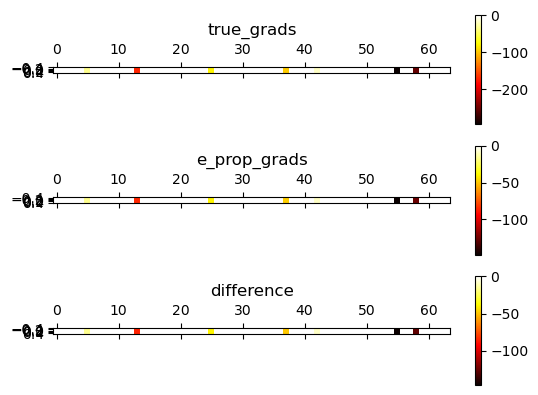

In [73]:
from matplotlib.colors import LogNorm
norm=None
# Plot heatmaps of true_grads and e_prop_grads tensor slices
fig, axs = plt.subplots(3, 1)

# Plot true_grads heatmap
im1 = axs[0].matshow(true_grads[2].detach(), cmap="hot", norm=norm)
axs[0].set_title("true_grads")

# Plot e_prop_grads heatmap
im2 = axs[1].matshow(e_prop_grads[2].detach(), cmap="hot", norm=norm)
axs[1].set_title("e_prop_grads")

# Plot difference heatmap
im3 = axs[2].matshow(true_grads[2].detach() - e_prop_grads[2].detach(), cmap="hot", norm=norm)
axs[2].set_title("difference")

# Add colorbars
fig.colorbar(im1, ax=axs[0])
fig.colorbar(im2, ax=axs[1])
fig.colorbar(im3, ax=axs[2])

# Show the plot
plt.show()

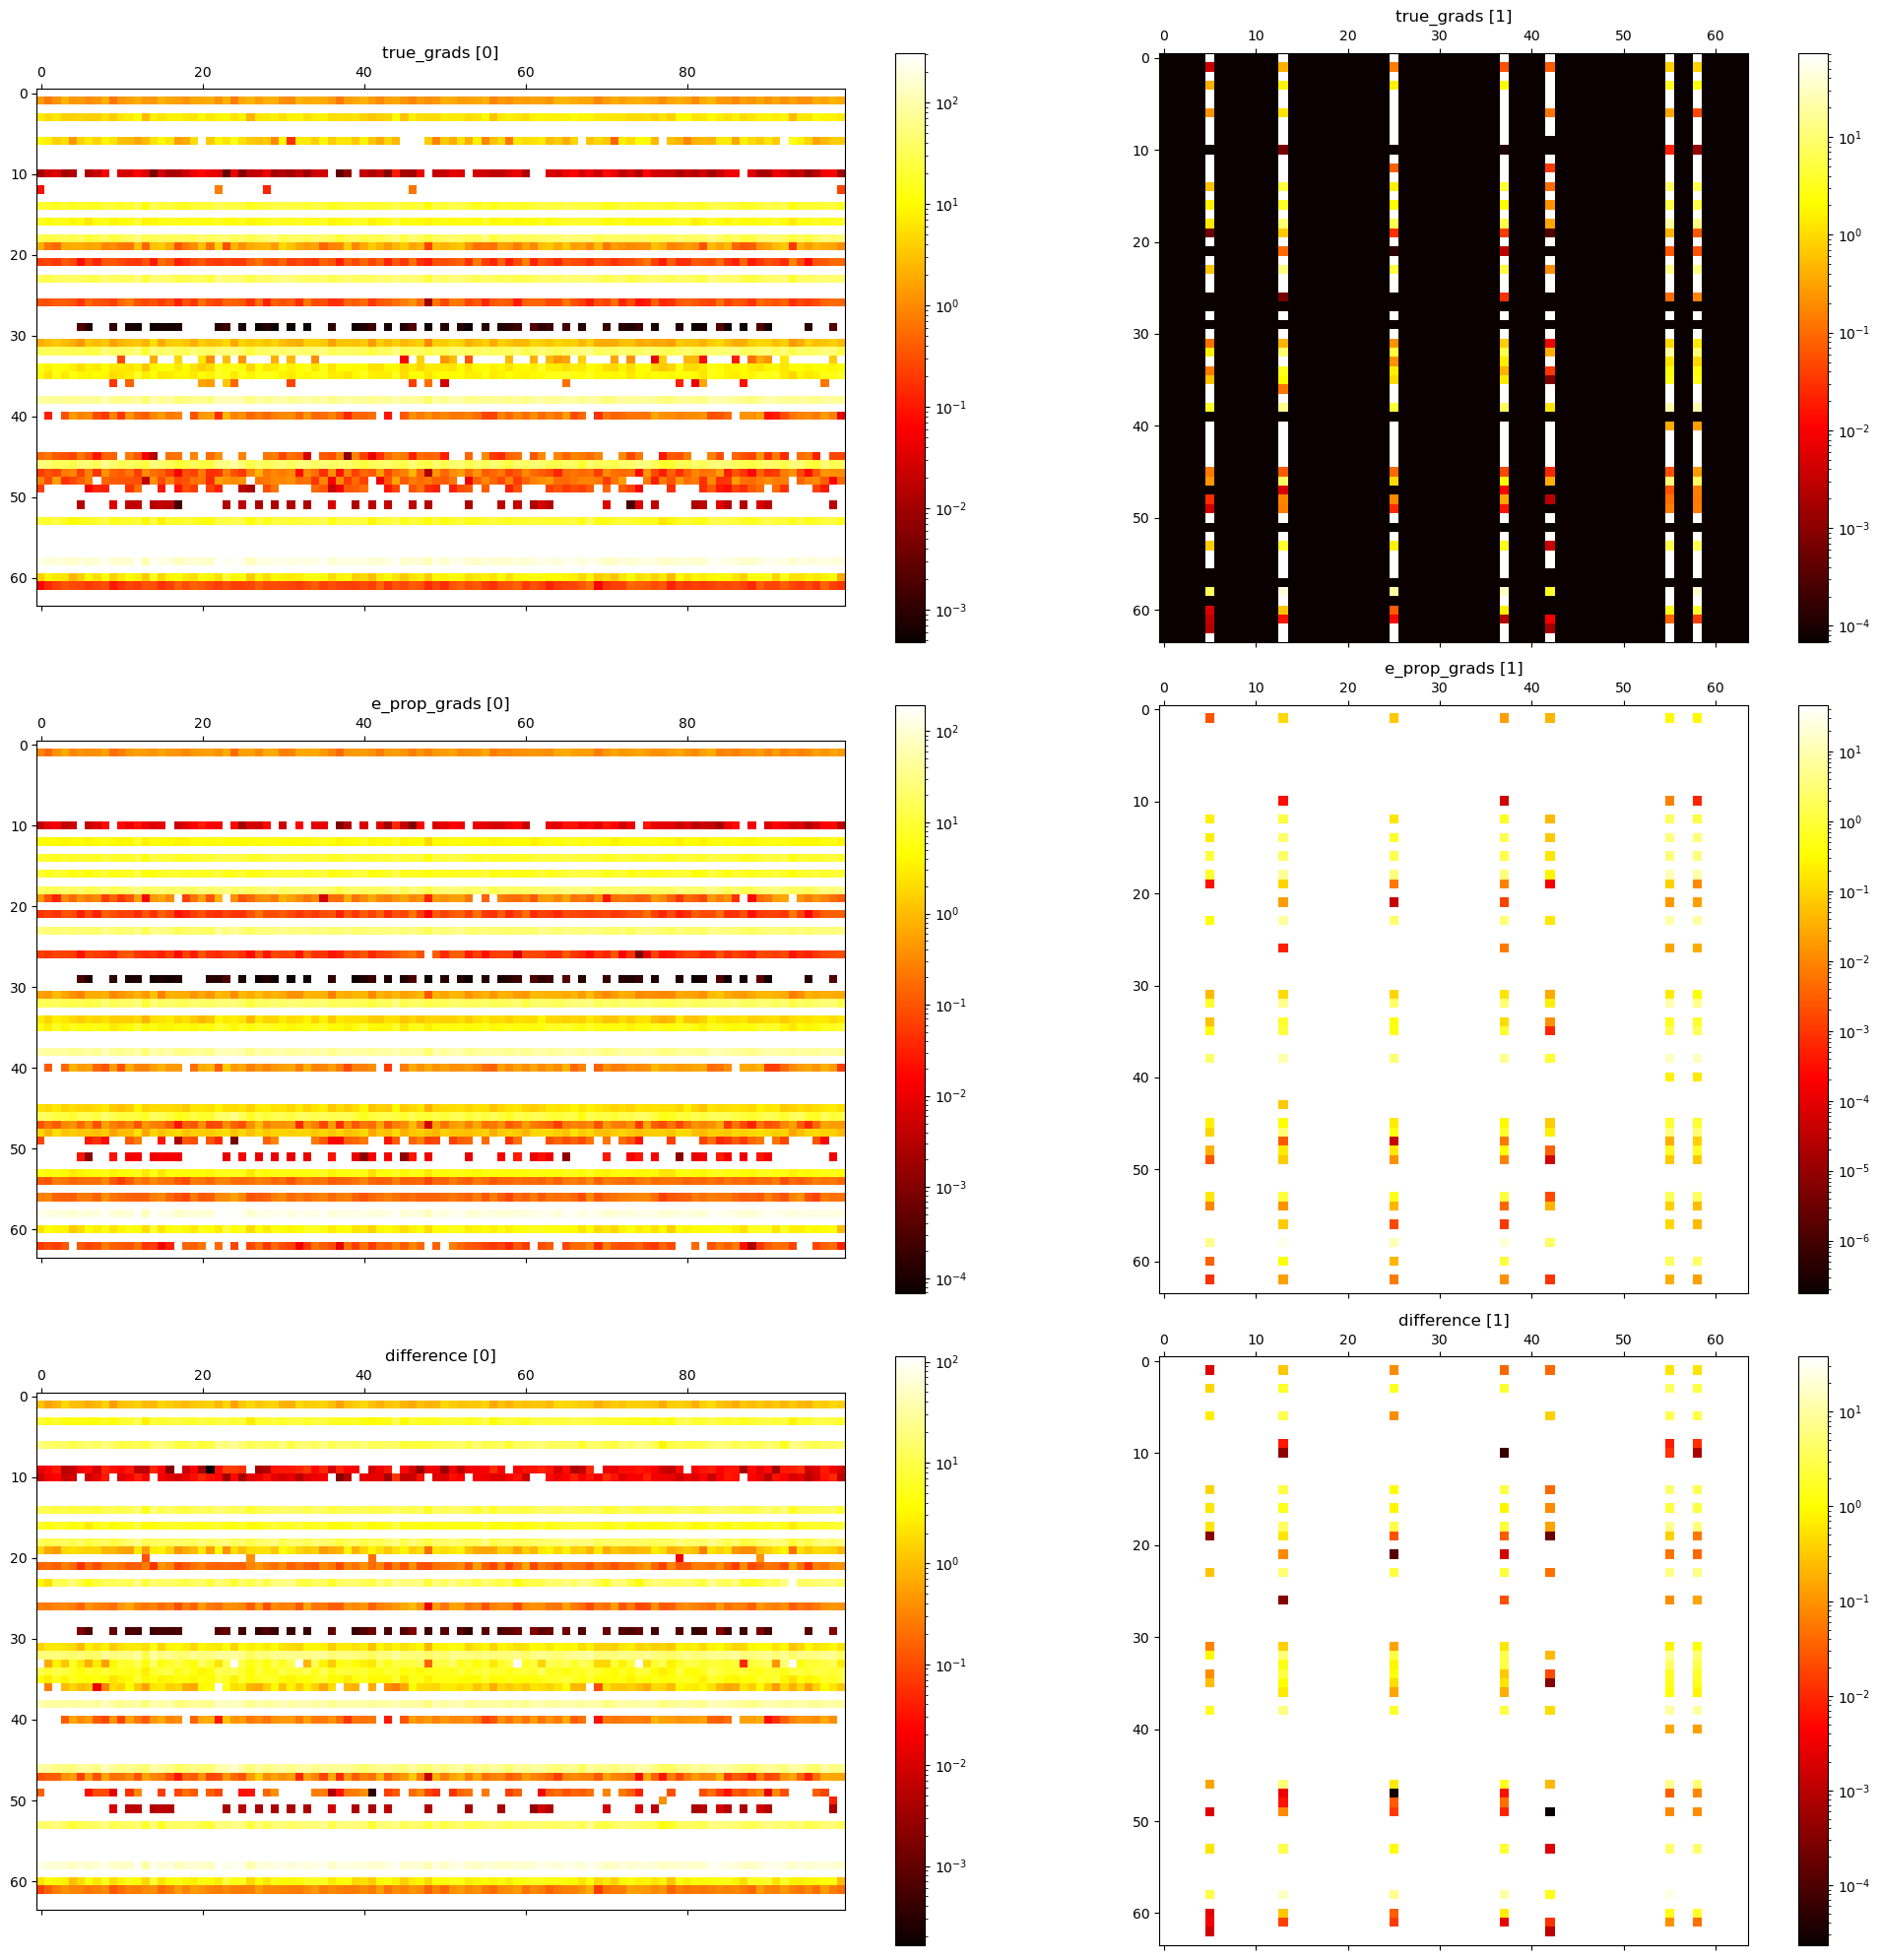

In [74]:
fig, axs = plt.subplots(3, 2, figsize=(20,20))

# Plot true_grads heatmap for [0] slice
im1 = axs[0, 0].matshow(true_grads[0].detach(), cmap="hot", norm=LogNorm())
axs[0, 0].set_title("true_grads [0]")

# Plot e_prop_grads heatmap for [0] slice
im2 = axs[1, 0].matshow(e_prop_grads[0].detach(), cmap="hot", norm=LogNorm())
axs[1, 0].set_title("e_prop_grads [0]")

# Plot difference heatmap for [0] slice
im3 = axs[2, 0].matshow(true_grads[0].detach() - e_prop_grads[0].detach(), cmap="hot", norm=LogNorm())
axs[2, 0].set_title("difference [0]")

# Plot true_grads heatmap for [1] slice
im4 = axs[0, 1].matshow(true_grads[1].detach(), cmap="hot", norm=LogNorm())
axs[0, 1].set_title("true_grads [1]")

# Plot e_prop_grads heatmap for [1] slice
im5 = axs[1, 1].matshow(e_prop_grads[1].detach(), cmap="hot", norm=LogNorm())
axs[1, 1].set_title("e_prop_grads [1]")

# Plot difference heatmap for [1] slice
im6 = axs[2, 1].matshow(true_grads[1].detach() - e_prop_grads[1].detach(), cmap="hot", norm=LogNorm())
axs[2, 1].set_title("difference [1]")

# Add colorbars
fig.colorbar(im1, ax=axs[0, 0])
fig.colorbar(im2, ax=axs[1, 0])
fig.colorbar(im3, ax=axs[2, 0])
fig.colorbar(im4, ax=axs[0, 1])
fig.colorbar(im5, ax=axs[1, 1])
fig.colorbar(im6, ax=axs[2, 1])

# Adjust spacing between subplots
fig.tight_layout()

# Show the plot
plt.show()

In [75]:
with torch.no_grad():
    preds, vo = net(data)
    loss = net.calc_loss(vo, targets)
    print(f"Loss after training: {loss}")


Loss after training: tensor([162.6372], dtype=torch.float64)


In [76]:
target_sinusoidal_outputs.shape, targets.shape, vo.shape

(torch.Size([1, 1000, 1]), torch.Size([1000, 1, 1]), torch.Size([1000, 1, 1]))

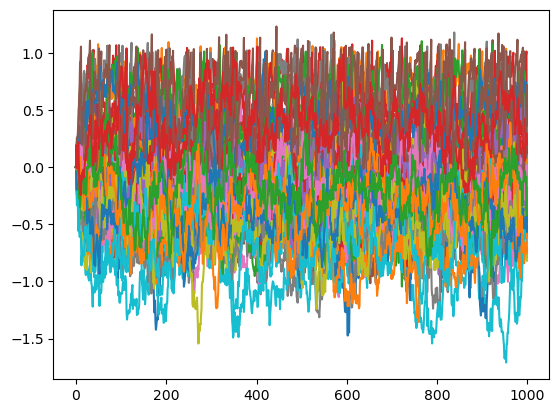

In [77]:
fig, axs = plt.subplots(1,1)
# axs.plot(target_sinusoidal_outputs[0])
axs.plot(net.v[:,0].detach())

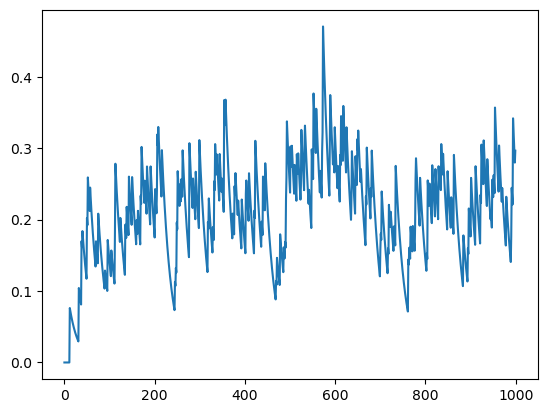

In [78]:
fig, axs = plt.subplots(1,1)
# axs.plot(target_sinusoidal_outputs[0])
axs.plot(net.vo[:,0].detach())

## Training loop

Note slightly strange example:
- Our training set consists only of 1 example, (input_spikes, target_sinusoids)
- We shall train for 100 epochs on this example
- We then test on that example

In [79]:
print(input_spikes.shape, target_sinusoidal_outputs.shape)

torch.Size([1, 1000, 100]) torch.Size([1, 1000, 1])


In [80]:
LR = 1e-4
optimizer = torch.optim.Adam(net.parameters(), lr=LR)

In [81]:
NUM_EPOCHS = 50
PRINT_EVERY_EPOCHS = 10
train_loss_hist = []
print(net.check_gradients)
# Outer training loop
for epoch in range(NUM_EPOCHS):
    # for data, targets in iter(dataloader))
    net.train()
    data, targets = input_spikes, target_sinusoidal_outputs  # would be next(iter(dataloader))
    data, targets = data.swapaxes(1, 0), targets.swapaxes(1,0)

    # Forward pass
    preds, vo = net(data)

    # Backward pass
    optimizer.zero_grad(set_to_none=False)
    loss = net.calc_loss(vo, targets)
    net.calc_grads(data, preds, targets)
    
    if net.check_gradients:
        net.update_weights()
    else:
        optimizer.step()

    # Store loss
    train_loss_hist.append(loss.item())

    # Print training statistics
    if epoch % PRINT_EVERY_EPOCHS == 0:
        train_printer(epoch, train_loss_hist)

True


Epoch 0
Train Set Loss: 162.64


Epoch 10
Train Set Loss: 96.71


Epoch 20
Train Set Loss: 104.66


Epoch 30
Train Set Loss: 79.46


Epoch 40
Train Set Loss: 71.48




## Plot results

### Learning curves

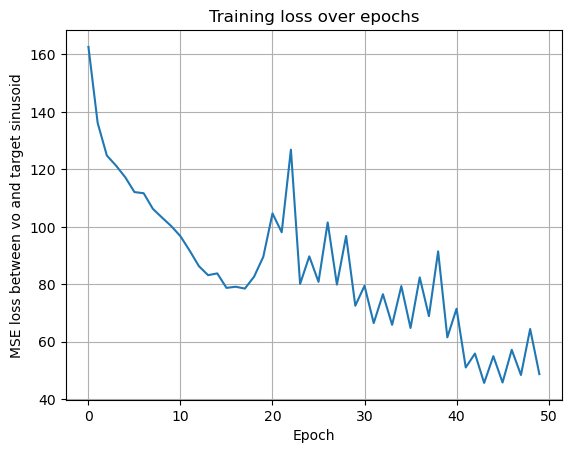

In [82]:
plt.title("Training loss over epochs")
plt.xlabel("Epoch")
plt.ylabel("MSE loss between vo and target sinusoid")
plt.plot(train_loss_hist)
# plt.ylim((0, 300))
plt.grid()

In [83]:
len(train_loss_hist)

50

### Output membrane voltage

Text(0, 0.5, 'Membrane voltage')

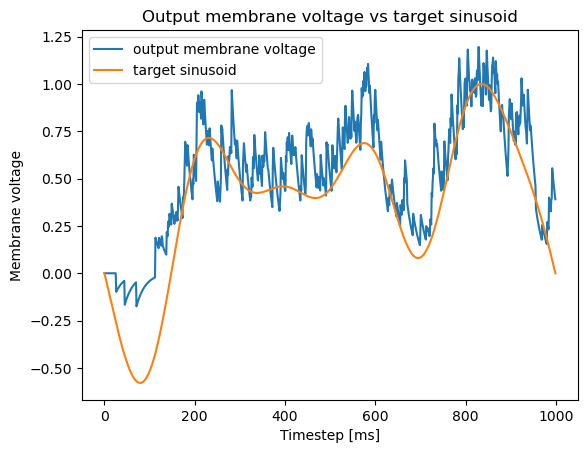

In [84]:
plt.plot(net.vo[:,0,0].detach(), label="output membrane voltage")
plt.plot(target_sinusoidal_outputs[0,:,0], label="target sinusoid")
plt.legend()
plt.title("Output membrane voltage vs target sinusoid")
plt.xlabel("Timestep [ms]")
plt.ylabel("Membrane voltage")

## Probe network

### Plot recurrent membrane potentials

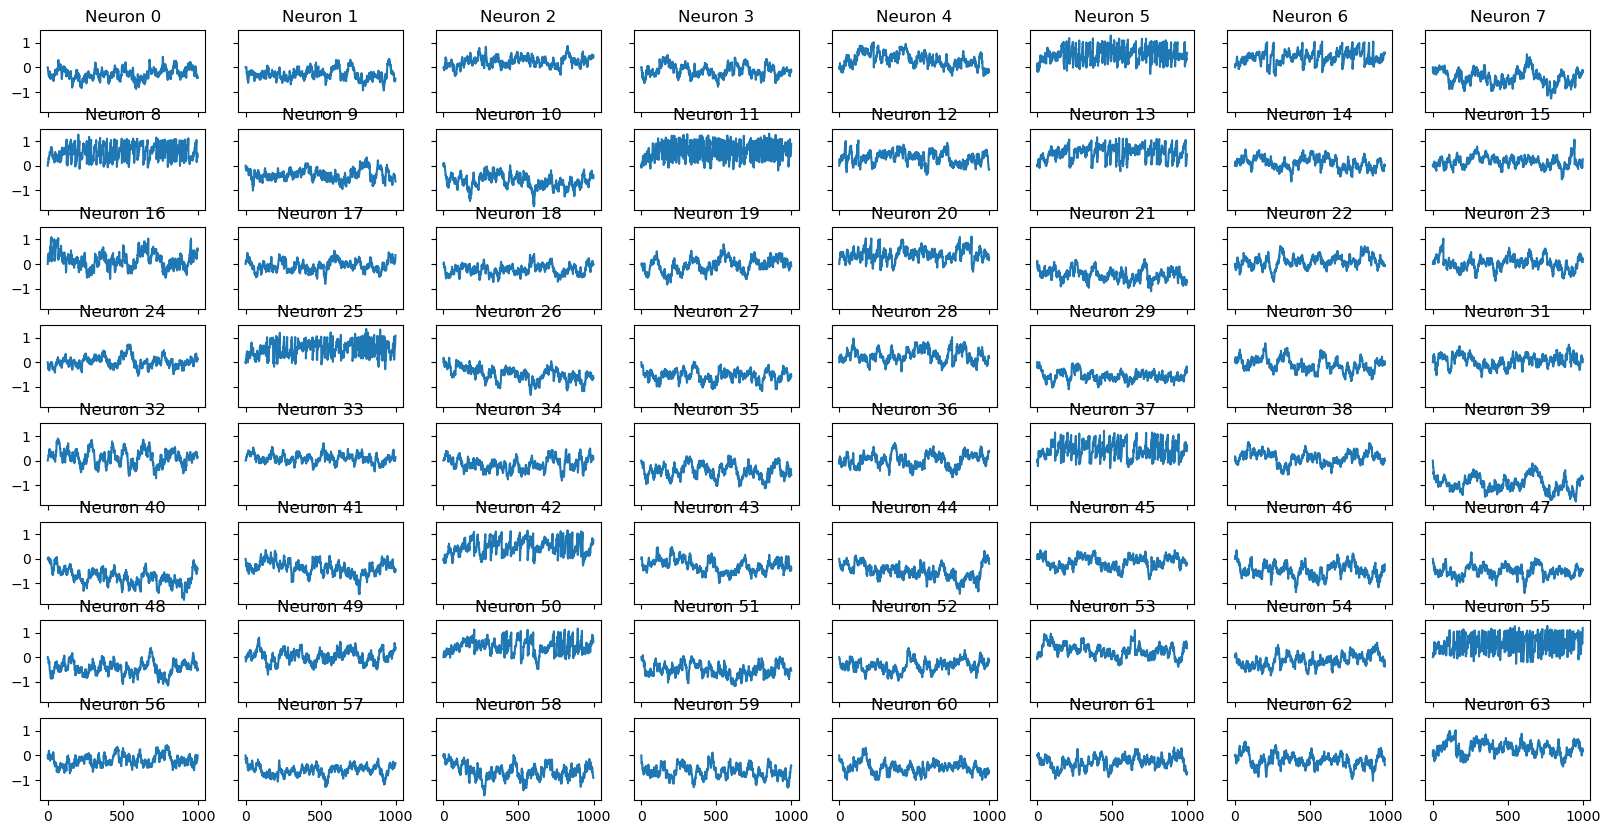

In [85]:
# Plot membrane voltage for all recurrent neurons
fig, axs = plt.subplots(8,8, figsize=(20, 10), sharex=True, sharey=True)
for i in range(8):
    for j in range(8):
        axs[i,j].plot(net.v[:,0,i*8+j].detach(), label="recurrent membrane voltage")
        axs[i,j].set_title(f"Neuron {i*8+j}")
        # axs[i,j].legend()

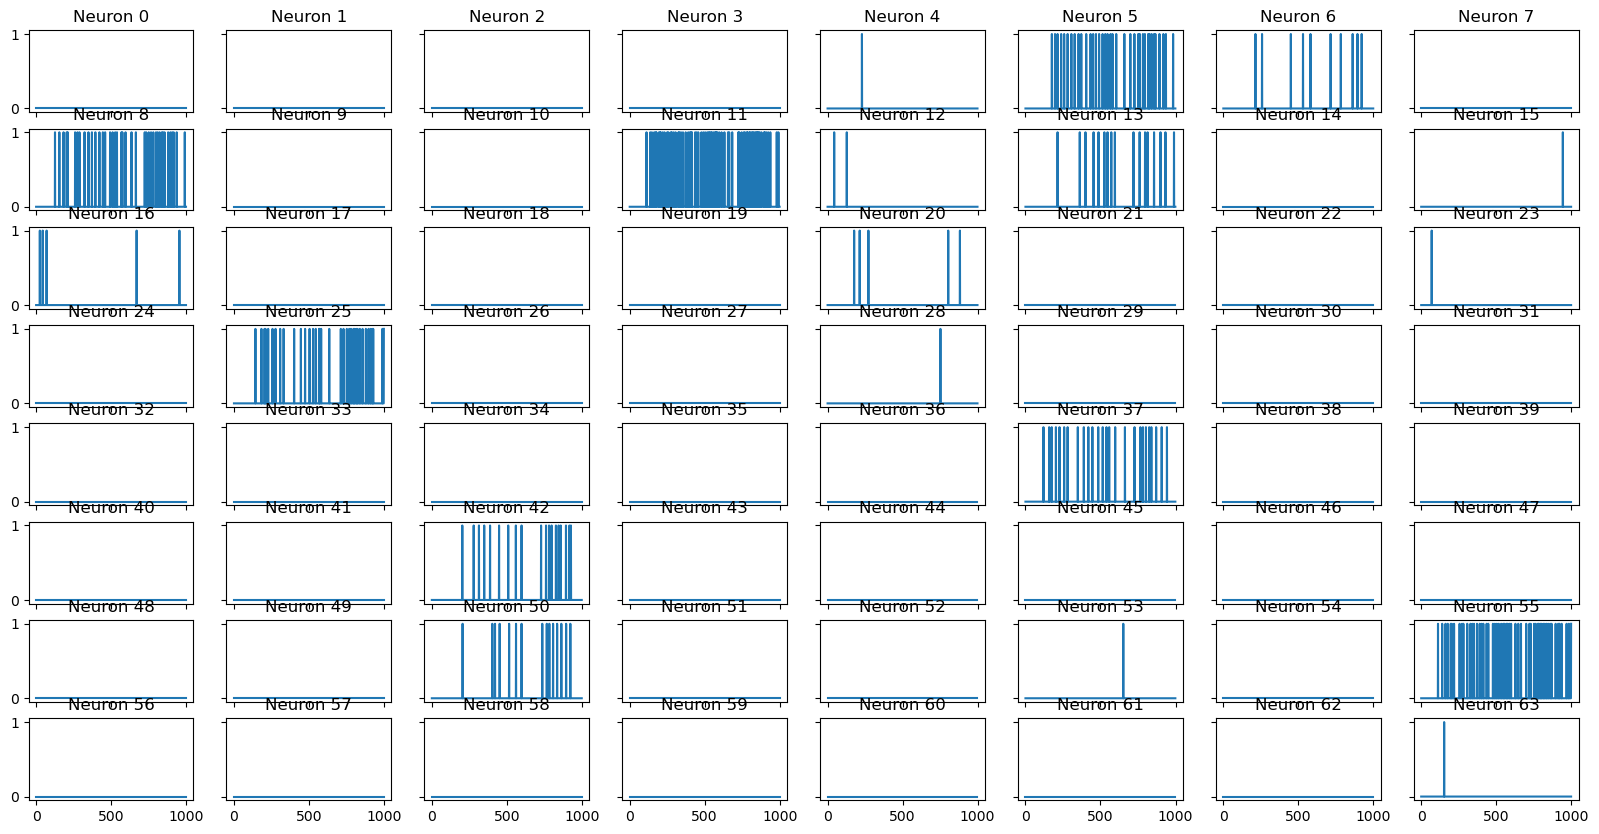

In [86]:
# Plot spikes for all recurrent neurons
fig, axs = plt.subplots(8,8, figsize=(20, 10), sharex=True, sharey=True)
for i in range(8):
    for j in range(8):
        axs[i,j].plot(net.z[:,0,i*8+j].detach(), label="recurrent spikes")
        axs[i,j].set_title(f"Neuron {i*8+j}")

### Check self connections and their gradients